In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

MISSING DATA:
 pelvic_incidence            0
pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondilolisthesis    0
age                         0
gender                      0
abdominal_pain              0
class                       0
dtype: int64
DUPLICATE VALUES: 0
Dataset Shape: (10000, 10)
class
Hernia               4200
Normal               3000
Spondilolisthesis    2800
Name: count, dtype: int64


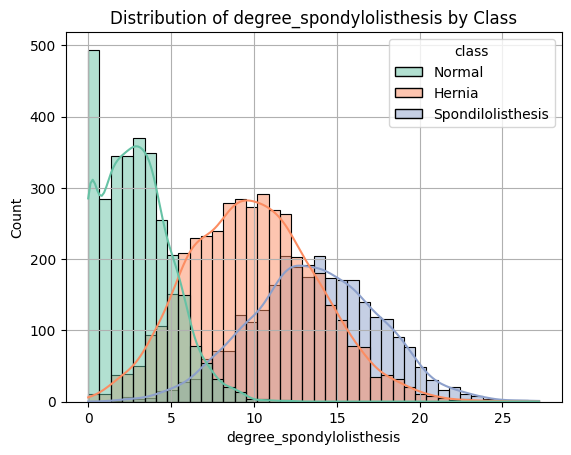

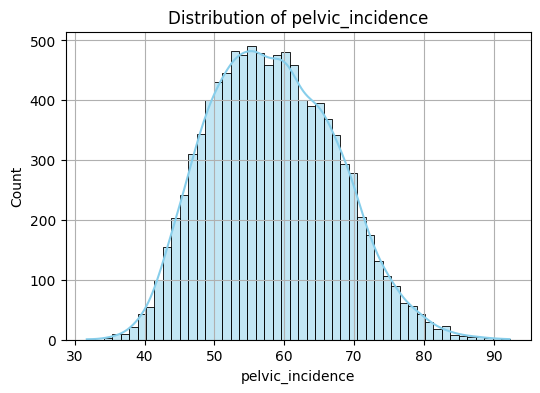

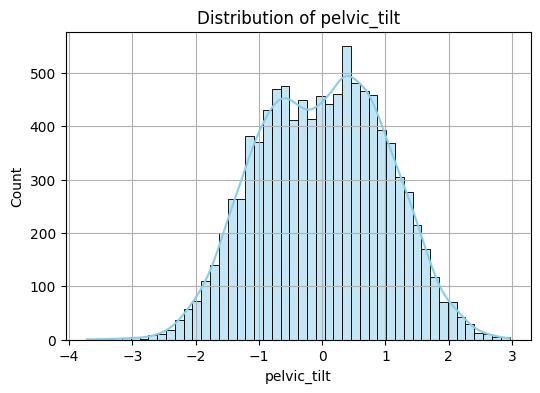

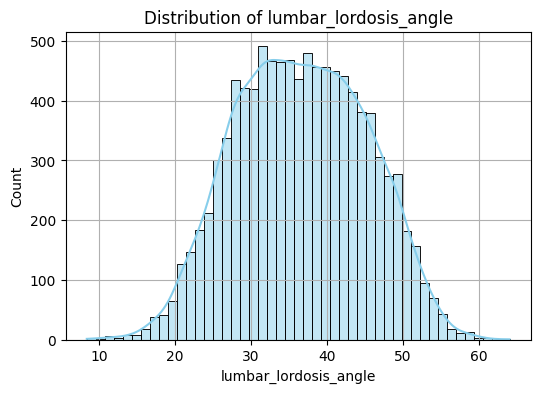

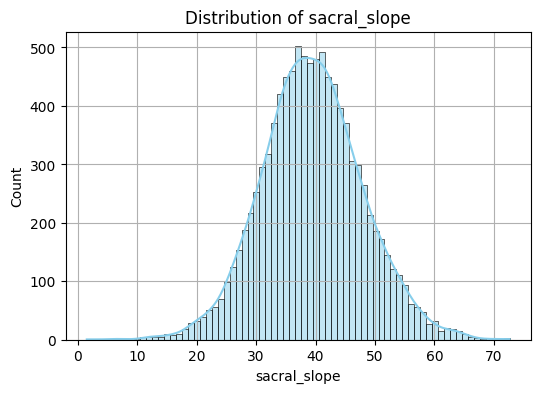

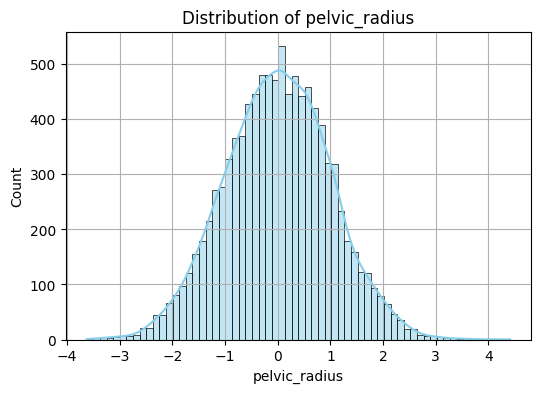

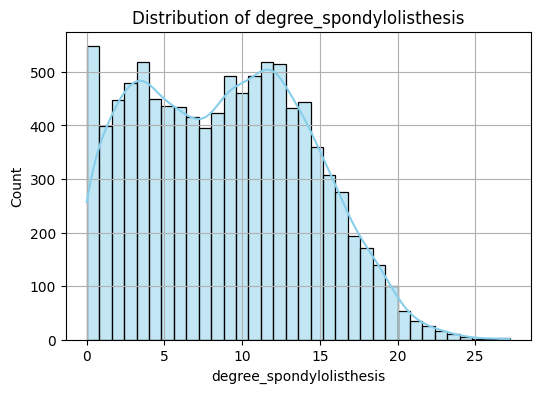

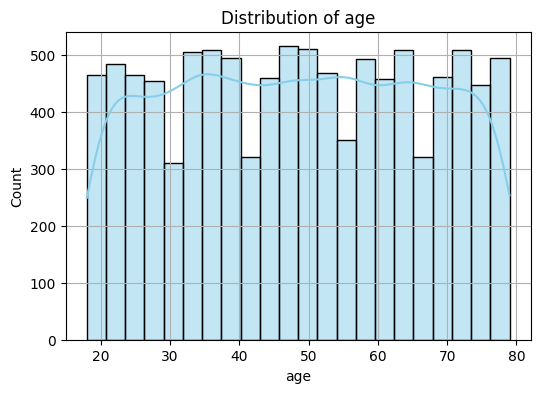

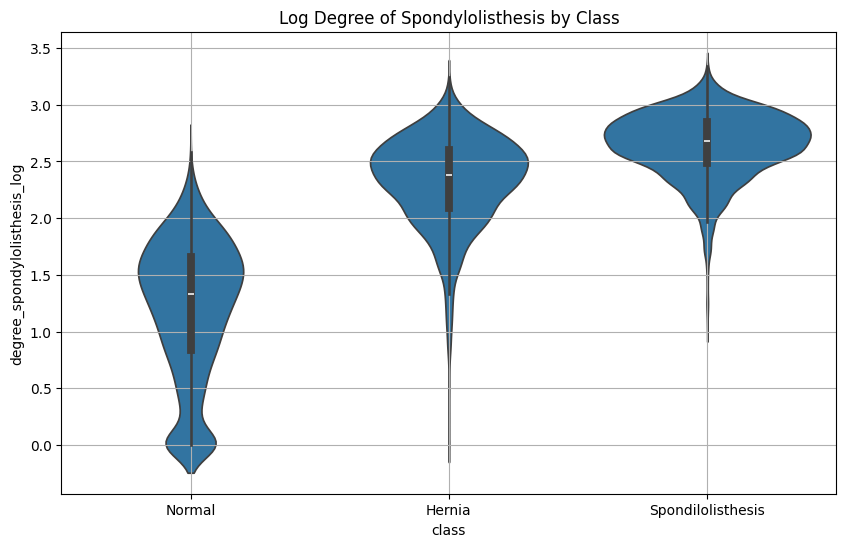

      lumbar_lordosis_angle   class
3                     57.80  Normal
38                    54.45  Normal
46                    54.67  Normal
64                    55.77  Normal
92                    55.22  Normal
...                     ...     ...
5978                  56.12  Hernia
6178                  58.13  Hernia
6454                  57.18  Hernia
6667                  55.01  Hernia
7123                  57.56  Hernia

[100 rows x 2 columns]


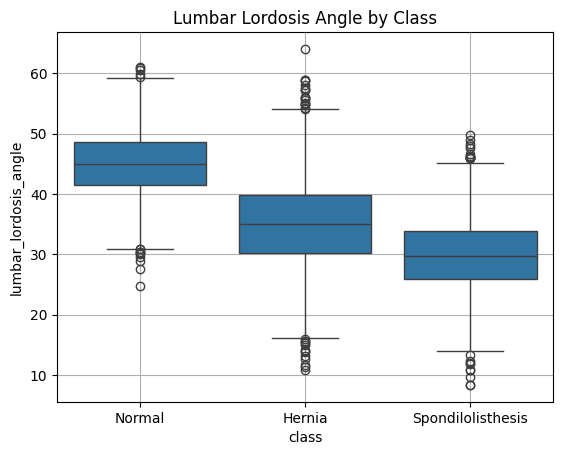

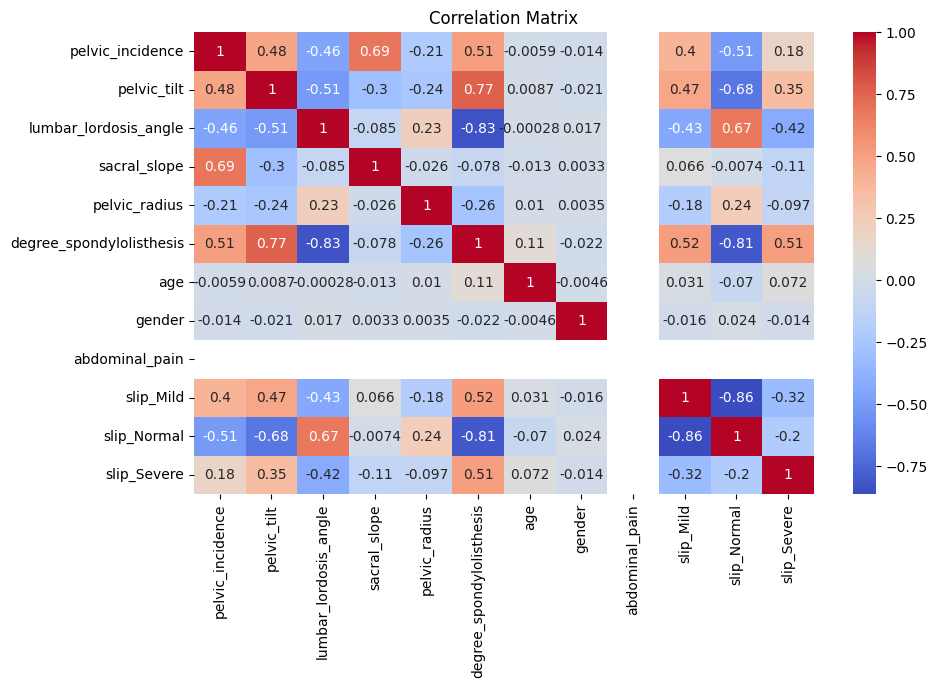

In [3]:


# Step 1: Load Dataset
df = pd.read_csv('/content/spine_data.csv')

# Check for missing values
print('MISSING DATA:\n', df.isnull().sum())

# Check for duplicate values
print('DUPLICATE VALUES:', df.duplicated().sum())

# View shape
print('Dataset Shape:', df.shape)

# Check class distribution
print(df['class'].value_counts())

# ============================================
# Step 2: Handle Categorical Features
# ============================================
# Encode gender and abdominal_pain
df['gender'] = df['gender'].str.lower().map({'male': 0, 'female': 1})
df['abdominal_pain'] = df['abdominal_pain'].astype(str).str.lower().map({'no': 0, 'yes': 1})

# ============================================
# Step 3: Clip invalid values and log transform
# ============================================
df['pelvic_tilt'] = df['pelvic_tilt'].clip(lower=0)
df['sacral_slope'] = df['sacral_slope'].clip(lower=0)
df['degree_spondylolisthesis'] = df['degree_spondilolisthesis'].clip(lower=0)

# Distribution histogram of degree_spondylolisthesis
sns.histplot(data=df, x='degree_spondylolisthesis', hue='class', bins=40, kde=True, palette='Set2')
plt.title('Distribution of degree_spondylolisthesis by Class')
plt.grid(True)
plt.show()

# Categorize slip
def categorize_slip(degree):
    if degree < 6:
        return 'Normal'
    elif degree < 17:
        return 'Mild'
    else:
        return 'Severe'

df['slip_category'] = df['degree_spondylolisthesis'].apply(categorize_slip)
df = pd.get_dummies(df, columns=['slip_category'], prefix='slip').astype({'slip_Mild': int, 'slip_Normal': int, 'slip_Severe': int})

# ============================================
# Step 4: Log & Power Transformation
# ============================================
df['degree_spondylolisthesis_log'] = np.log1p(df['degree_spondylolisthesis'])

pt = PowerTransformer()
df[['pelvic_tilt_pt', 'pelvic_radius_pt']] = pt.fit_transform(df[['pelvic_tilt', 'pelvic_radius']])
df['pelvic_tilt'] = df['pelvic_tilt_pt']
df['pelvic_radius'] = df['pelvic_radius_pt']
df.drop(columns=['pelvic_tilt_pt', 'pelvic_radius_pt'], inplace=True)

# ============================================
# Step 5: Visualizations (Activated)
# ============================================
numeric_features = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle',
                    'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'age']

for col in numeric_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()

# Violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='class', y='degree_spondylolisthesis_log', data=df)
plt.title("Log Degree of Spondylolisthesis by Class")
plt.grid(True)
plt.show()

# Outlier Investigation
outliers = df[df['lumbar_lordosis_angle'] > df['lumbar_lordosis_angle'].quantile(0.99)]
print(outliers[['lumbar_lordosis_angle', 'class']])

sns.boxplot(x='class', y='lumbar_lordosis_angle', data=df)
plt.title("Lumbar Lordosis Angle by Class")
plt.grid(True)
plt.show()

# ============================================
# Step 6: Prepare for Modeling
# ============================================
df_rf = df.copy()
df_capped = df.copy()

# Cap outliers for sensitive models
for col in ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle',
            'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']:
    lower = df_capped[col].quantile(0.01)
    upper = df_capped[col].quantile(0.99)
    df_capped[col] = df_capped[col].clip(lower, upper)

# Final feature list for correlation + models
features = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle',
            'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'age',
            'gender', 'abdominal_pain', 'slip_Mild', 'slip_Normal', 'slip_Severe']

plt.figure(figsize=(10, 6))
sns.heatmap(df_capped[features].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# ============================================
# Step 7: Train-Test Split & Scaling
# ============================================
# For Logistic Regression and SVC
X = df_capped[features]
y = df_capped['class']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# joblib.dump(scaler, 'scaler_std.pkl')

# For Random Forest
X_rf = df_rf[features]
y_rf = df_rf['class']
y_rf_encoded = label_encoder.fit_transform(y_rf)
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(
    X_rf, y_rf_encoded, test_size=0.2, random_state=42, stratify=y_rf_encoded
)


In [7]:
# Standardize and map gender values
df['gender'] = df['gender'].astype(str).str.strip().str.lower()
df['gender'] = df['gender'].map({'male': 0, 'female': 1})
if df['gender'].isnull().any():
    mode_gender = df['gender'].dropna().mode()
    df['gender'].fillna(mode_gender[0] if not mode_gender.empty else 0, inplace=True)

# Standardize and map abdominal_pain values
df['abdominal_pain'] = df['abdominal_pain'].astype(str).str.strip().str.lower()
df['abdominal_pain'] = df['abdominal_pain'].map({'no': 0, 'yes': 1})
if df['abdominal_pain'].isnull().any():
    mode_pain = df['abdominal_pain'].dropna().mode()
    df['abdominal_pain'].fillna(mode_pain[0] if not mode_pain.empty else 0, inplace=True)

# Fix age column
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df['age'].fillna(df['age'].median(), inplace=True)


In [9]:
print("NaNs in features before scaling:")
print(X_train.isnull().sum())
print(X_test.isnull().sum())


NaNs in features before scaling:
pelvic_incidence               0
pelvic_tilt                    0
lumbar_lordosis_angle          0
sacral_slope                   0
pelvic_radius                  0
degree_spondylolisthesis       0
age                            0
gender                         0
abdominal_pain              8000
slip_Mild                      0
slip_Normal                    0
slip_Severe                    0
dtype: int64
pelvic_incidence               0
pelvic_tilt                    0
lumbar_lordosis_angle          0
sacral_slope                   0
pelvic_radius                  0
degree_spondylolisthesis       0
age                            0
gender                         0
abdominal_pain              2000
slip_Mild                      0
slip_Normal                    0
slip_Severe                    0
dtype: int64


In [11]:
modes = X_train['abdominal_pain'].mode()
if not modes.empty:
    mode_ab_pain = modes[0]
else:
    # fallback default if no mode
    mode_ab_pain = 0

X_train['abdominal_pain'].fillna(mode_ab_pain, inplace=True)
X_test['abdominal_pain'].fillna(mode_ab_pain, inplace=True)


In [12]:
print("NaNs in features before scaling:")
print(X_train.isnull().sum())
print(X_test.isnull().sum())


NaNs in features before scaling:
pelvic_incidence            0
pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
age                         0
gender                      0
abdominal_pain              0
slip_Mild                   0
slip_Normal                 0
slip_Severe                 0
dtype: int64
pelvic_incidence            0
pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
age                         0
gender                      0
abdominal_pain              0
slip_Mild                   0
slip_Normal                 0
slip_Severe                 0
dtype: int64


In [14]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# -------- Logistic Regression Pipeline --------
pipe_lr = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # impute missing values
    ('scaler', StandardScaler()),                           # scale features
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

param_grid_lr = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs', 'saga']
}

grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=5, n_jobs=-1, scoring='accuracy')
grid_lr.fit(X_train, y_train)

print("\n📌 Logistic Regression Results:")
print("Best Params:", grid_lr.best_params_)
print("Train Accuracy:", grid_lr.score(X_train, y_train))
print("Test Accuracy:", grid_lr.score(X_test, y_test))

y_pred_lr = grid_lr.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))


# -------- Support Vector Classifier Pipeline --------
pipe_svc = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),
    ('clf', SVC(max_iter=1000))
])

param_grid_svc = {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf'],
    'clf__gamma': ['scale', 'auto']
}

grid_svc = GridSearchCV(pipe_svc, param_grid_svc, cv=5, n_jobs=-1, scoring='accuracy')
grid_svc.fit(X_train, y_train)

print("\n📌 SVC Results:")
print("Best Params:", grid_svc.best_params_)
print("Train Accuracy:", grid_svc.score(X_train, y_train))
print("Test Accuracy:", grid_svc.score(X_test, y_test))

y_pred_svc = grid_svc.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred_svc))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svc))


# -------- Random Forest Pipeline --------
pipe_rf = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('clf', RandomForestClassifier(class_weight='balanced'))
])

param_grid_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__bootstrap': [True, False]
}

grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, n_jobs=-1, scoring='accuracy')
grid_rf.fit(X_train, y_train)

print("\n📌 Random Forest Results:")
print("Best Params:", grid_rf.best_params_)
print("Train Accuracy:", grid_rf.score(X_train, y_train))
print("Test Accuracy:", grid_rf.score(X_test, y_test))

y_pred_rf = grid_rf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))



📌 Logistic Regression Results:
Best Params: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Train Accuracy: 0.793
Test Accuracy: 0.785
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.69      0.73       840
           1       0.92      0.97      0.95       600
           2       0.66      0.73      0.69       560

    accuracy                           0.79      2000
   macro avg       0.78      0.80      0.79      2000
weighted avg       0.79      0.79      0.78      2000

Confusion Matrix:
 [[578  50 212]
 [ 15 585   0]
 [151   2 407]]

📌 SVC Results:
Best Params: {'clf__C': 1, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
Train Accuracy: 0.71225
Test Accuracy: 0.712
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.43      0.56       840
           1       0.92      0.97      0.95       600
           2       0.53      0.85      0.65       560

    ac

In [15]:
import joblib
from sklearn.metrics import classification_report, confusion_matrix

# Logistic Regression evaluation
print("\nLogistic Regression Evaluation:")
y_pred_lr = grid_lr.predict(X_test)  # raw test features, no manual scaling
print("Classification Report:\n", classification_report(y_test, y_pred_lr))
print("-------------------------------------------------------------")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
joblib.dump(grid_lr, 'lr_spinal.pkl')

# SVC evaluation
print("\nSVC Evaluation:")
y_pred_svc = grid_svc.predict(X_test)  # raw test features
print("Classification Report:\n", classification_report(y_test, y_pred_svc))
print("-------------------------------------------------------------")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svc))
joblib.dump(grid_svc, 'svc_spinal.pkl')

# Random Forest evaluation
print("\nRandom Forest Evaluation:")
y_pred_rf = grid_rf.predict(X_rf_test)  # raw RF test features (no scaling needed)
print("Classification Report:\n", classification_report(y_rf_test, y_pred_rf, target_names=["Normal", "Hernia", "Spondylolisthesis"]))
print("-------------------------------------------------------------")
print("Confusion Matrix:\n", confusion_matrix(y_rf_test, y_pred_rf))
joblib.dump(grid_rf, 'rf_spinal.pkl')



Logistic Regression Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.69      0.73       840
           1       0.92      0.97      0.95       600
           2       0.66      0.73      0.69       560

    accuracy                           0.79      2000
   macro avg       0.78      0.80      0.79      2000
weighted avg       0.79      0.79      0.78      2000

-------------------------------------------------------------
Confusion Matrix:
 [[578  50 212]
 [ 15 585   0]
 [151   2 407]]

SVC Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.43      0.56       840
           1       0.92      0.97      0.95       600
           2       0.53      0.85      0.65       560

    accuracy                           0.71      2000
   macro avg       0.75      0.75      0.72      2000
weighted avg       0.76      0.71      0.70      2000

-------------

['rf_spinal.pkl']

In [17]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Model Evaluation Summary Function
def model_summary(model_name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    class_report = classification_report(y_true, y_pred, output_dict=True)
    f1_score = class_report['weighted avg']['f1-score']  # Overall F1-score for comparison
    precision = class_report['weighted avg']['precision']
    recall = class_report['weighted avg']['recall']

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1_score
    }

# Assume you already have predictions for LR and SVC:
# y_pred_lr, y_pred_svc from earlier code

# Predict on the Random Forest test set (make sure to do this before evaluation)
rf_preds = grid_rf.predict(X_rf_test)

# Gather evaluation metrics for each model
model_results = []
model_results.append(model_summary("Logistic Regression", y_test, y_pred_lr))
model_results.append(model_summary("SVC", y_test, y_pred_svc))
model_results.append(model_summary("Random Forest", y_rf_test, rf_preds))

# Display summary in a DataFrame for easy comparison
summary_df = pd.DataFrame(model_results)

print("\nModel Performance Summary:")
print(summary_df)

# Selecting the best model based on highest F1-score (or other metric)
best_model = summary_df.loc[summary_df['F1-score'].idxmax()]
print(f"\nBest Model Selection based on F1-score: {best_model['Model']}")

# Feature importance for Random Forest best estimator
best_rf_model = grid_rf.best_estimator_.named_steps['clf']
print("\nRandom Forest Feature Importances:")
for feature, importance in zip(X_rf_train.columns, best_rf_model.feature_importances_):
    print(f"{feature}: {importance:.4f}")

# Decode encoded labels back to original class names using label_encoder
y_rf_test_labels = label_encoder.inverse_transform(y_rf_test)
rf_preds_labels = label_encoder.inverse_transform(rf_preds)

# Identify misclassified Hernia samples by Random Forest
misclassified_hernia = (y_rf_test_labels == 'Hernia') & (rf_preds_labels != 'Hernia')

print("\nMisclassified Hernia samples:")
print(X_rf_test.loc[misclassified_hernia])



Model Performance Summary:
                 Model  Accuracy  Precision  Recall  F1-score
0  Logistic Regression    0.7850   0.785904  0.7850  0.783583
1                  SVC    0.7120   0.755232  0.7120  0.701082
2        Random Forest    0.7915   0.787686  0.7915  0.788692

Best Model Selection based on F1-score: Random Forest

Random Forest Feature Importances:
pelvic_incidence: 0.1413
pelvic_tilt: 0.1877
lumbar_lordosis_angle: 0.1384
sacral_slope: 0.0708
pelvic_radius: 0.0628
degree_spondylolisthesis: 0.2228
age: 0.0416
gender: 0.0070
abdominal_pain: 0.0000
slip_Mild: 0.0359
slip_Normal: 0.0823
slip_Severe: 0.0094

Misclassified Hernia samples:
      pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  \
6869             70.04    -0.175497                  29.28         52.92   
5982             58.83    -1.188472                  41.32         47.84   
4981             41.70     0.239752                  49.15         21.70   
4794             69.90     0.248087    

In [18]:
import joblib

# Save the trained models (GridSearchCV objects with pipelines)
joblib.dump(grid_lr, 'spine_lr.pkl')
joblib.dump(grid_svc, 'spine_svc.pkl')
joblib.dump(grid_rf, 'spine_rf.pkl')

# Save the StandardScaler used in the pipeline (if you need it separately)
joblib.dump(scaler, 'scaler.pkl')

# Save the PowerTransformer used for feature transformation (optional, uncomment if used separately)
joblib.dump(pt, 'power_transformer.pkl')

print("Models and preprocessors saved successfully.")


Models and preprocessors saved successfully.
